In [52]:
# Libraries (will need to export to requirements.txt)

from SPARQLWrapper import SPARQLWrapper, JSON
import wikipedia
from tqdm import tqdm
import os
import json
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import glob
import re

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Pull 100 biographies from wikipedia for each category

In [3]:
DATA_PATH = 'data/'
CATEGORY1 = 'Rabbi'
CATEGORY2 = 'Drag queen'

In [4]:
def get_people(profession):
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    
    modified_profession = profession.replace(' ', '_').replace("'", '%27')
    
    query = """
            Select Distinct ?person Where {
                ?person dbo:occupation dbr:%s .
            }
            """ % modified_profession
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    ret = sparql.queryAndConvert()
    return(ret['results']['bindings'])

In [5]:
def get_rdf_triples(person):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    dbpedia_resource = "http://dbpedia.org/resource/" + person
    query = "SELECT ?predicate ?object WHERE { <" + dbpedia_resource + "> ?predicate ?object.}"
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    triples = []
    for result in results["results"]["bindings"]:
        subj = "<"+dbpedia_resource+">"
        pred = result["predicate"]["value"]
        obj = result["object"]["value"]
        triples.append({'subject': subj, 'predicate': pred, 'object': obj})
    return triples

In [6]:
def get_biographies(people, category, limit):
    pages = []
    i = 0
    if not os.path.exists(DATA_PATH):
        print('Data Directory did not exist, creating it now...')
        os.mkdir(DATA_PATH)

    with tqdm(total=limit) as pbar:
        while len(pages) < limit:
            if i >= len(people):
                break
            person = people[i]['person']['value'].split('/')[-1]
            try:
                page = wikipedia.page(person).content
                pages.append(page)
                file_path = os.path.join(DATA_PATH, person + '_' + category.replace(' ', '_'))
                with open(file_path + '.txt', 'w') as f:
                    f.write(page)
                triples = get_rdf_triples(person)
                with open(file_path + '.json', 'w') as f:
                    json.dump(triples, f, indent=4)
                pbar.update(1)
            except Exception as e:
                pass
            i += 1
    return pages

In [7]:
def create_dataset(cat1, cat2, limit=999):
    people1, people2 = (get_people(cat1), get_people(cat2))
    texts1, texts2 = (get_biographies(people1, cat1, limit), get_biographies(people2, cat2, limit))
    df = pd.DataFrame({'text' : texts1+texts2})
    df['category'] = pd.Series([cat1]*len(texts1) + [cat2]*len(texts2))
    return df, texts1, texts2

In [8]:
df, texts1, texts2 = create_dataset(CATEGORY1, CATEGORY2, limit=100)

 56%|█████▌    | 56/100 [05:29<04:23,  5.99s/it]c:\Users\Salman\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Salman\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
 93%|█████████▎| 93/100 [09:07<00:41,  5.89s/it]


In [9]:
def clean_text_complete(text):
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    return text.lower()

In [10]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [11]:
df.head()

,text,category
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi


In [12]:
df['clean_text'] = df['text'].apply(clean_text_complete)

In [13]:
df['tokenized'] = df['clean_text'].apply(tokenize)

In [14]:
# Create 50 most common word per category and word cloud

In [15]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens

In [16]:
tokens1 = get_all_tokens(df, CATEGORY1)
tokens2 = get_all_tokens(df, CATEGORY2)

In [17]:
def remove_stopwords(tokens, stop_words):
    '''
    This function removes stopwords from a list of tokens.
    Parameters:
    - tokens = list of tokens.
    - stop_words = list of stopwords
    Output: 
    - tokens = list of tokens without stopwords 
    '''
    for token in tokens:
        if token in stop_words:
            tokens.remove(token)
    return tokens

In [18]:
stopwords_en = stopwords.words('english') #I added into a list variable to fix the function.

In [19]:
tokens1_nostop = remove_stopwords(tokens1, stopwords_en)
tokens2_nostop = remove_stopwords(tokens2, stopwords_en)

In [20]:
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

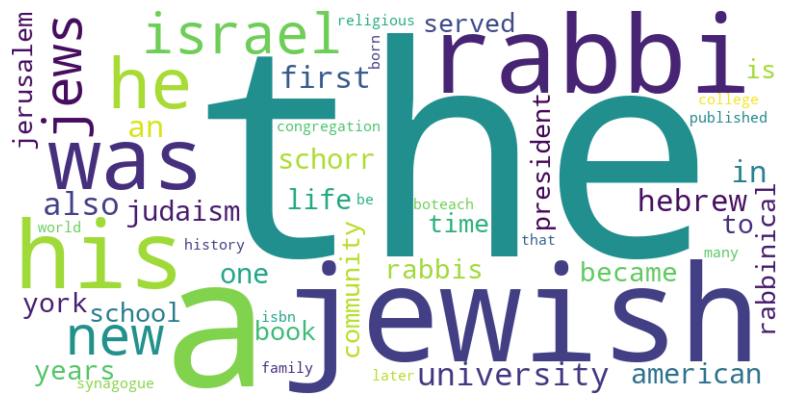

In [21]:
make_wordcloud(tokens1_nostop, 50)

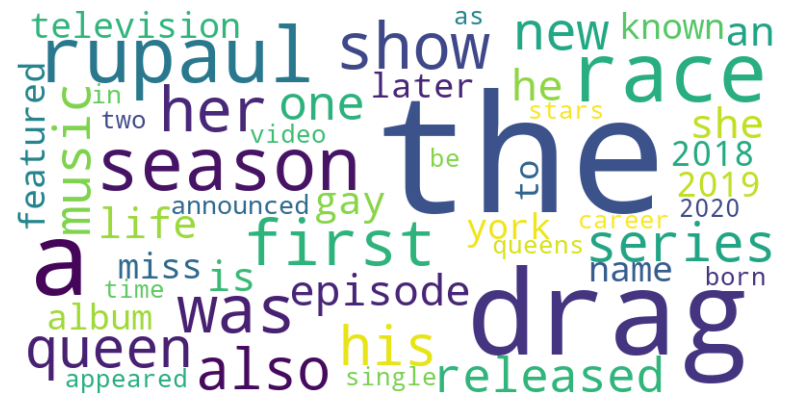

In [22]:
make_wordcloud(tokens2_nostop, 50)

In [23]:
# Create histogram and boxplot for sentence length per category with min/max/avg

Attention:
This changed after I fixed the stopwords function. 
We need to review it carefully because I don't see the tokens element here

In [24]:
df.head()

,text,category,clean_text,tokenized
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"[capers, c, funnye, jr, born, april, 14, 1952,..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"[samuel, adler, december, 3, 1809, –, june, 9,..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"[elie, abadie, arabic, ايلي, عبادي, is, senior..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"[menahem, shemuel, halevy, hebrew, מנחם, שמואל..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"[rabbi, menachem, mendel, monsohn, hebrew, מנח..."


In [25]:
def get_sentences(series):
    sentences = []
    for item in series:
        for para in item.split('\n'):
            for sent in nltk.sent_tokenize(para):
                sentences.append(sent)
    return sentences

In [26]:
sentences1 = get_sentences(df[df['category'] == CATEGORY1]['text']) 
sentences2 = get_sentences(df[df['category'] == CATEGORY2]['text'])

In [27]:
def get_length_dict(sentences):
    lengths = {}
    longest_sentence = ""
    shortest_sentence = "Pretty sure it's smaller than this"
    for sentence in sentences:
        len_sentence = len(sentence.split(' '))
        if len_sentence > len(longest_sentence.split(' ')):
            longest_sentence = sentence
        if len_sentence < len(shortest_sentence.split(' ')):
            shortest_sentence = sentence
        if lengths.get(len_sentence):
            lengths[len_sentence] += 1
        else:
            lengths[len_sentence] = 1
    expanded = []
    for key, count in lengths.items():
        expanded.extend([key] * count)
    return lengths, expanded, longest_sentence, shortest_sentence

In [28]:
length_sentence1, expanded1, longest_sentence1, shortest_sentence1 = get_length_dict(sentences1)
length_sentence2, expanded2, longest_sentence2, shortest_sentence2 = get_length_dict(sentences2)

In [29]:
print('Min Sentence Length Category 1:', min(length_sentence1))
print('Max Sentence Length Category 1:', max(length_sentence1))
print('Avg Sentence Length Category 1:', sum(length_sentence1) / len(length_sentence1))
print('Min Sentence Length Category 2:', min(length_sentence2))
print('Max Sentence Length Category 2:', max(length_sentence2))
print('Avg Sentence Length Category 2:', sum(length_sentence2) / len(length_sentence2))

Min Sentence Length Category 1: 1
Max Sentence Length Category 1: 129
Avg Sentence Length Category 1: 45.1764705882353
Min Sentence Length Category 2: 1
Max Sentence Length Category 2: 108
Avg Sentence Length Category 2: 39.38666666666666


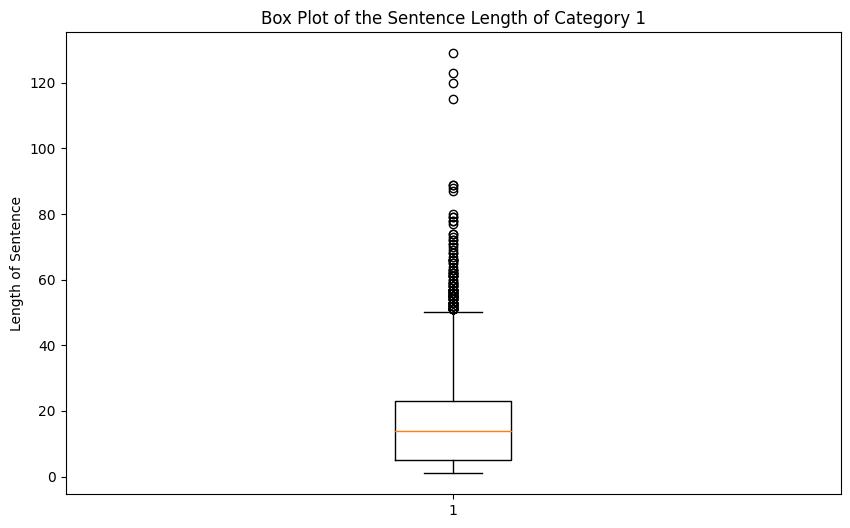

In [30]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded1)
plt.title("Box Plot of the Sentence Length of Category 1")
plt.ylabel("Length of Sentence")
plt.show()

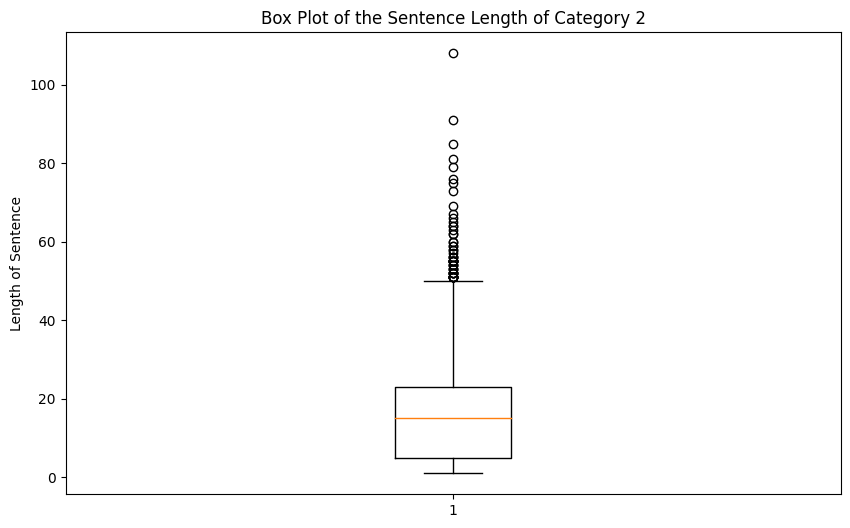

In [31]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded2)
plt.title("Box Plot of the Sentence Length of Category 2")
plt.ylabel("Length of Sentence")
plt.show()

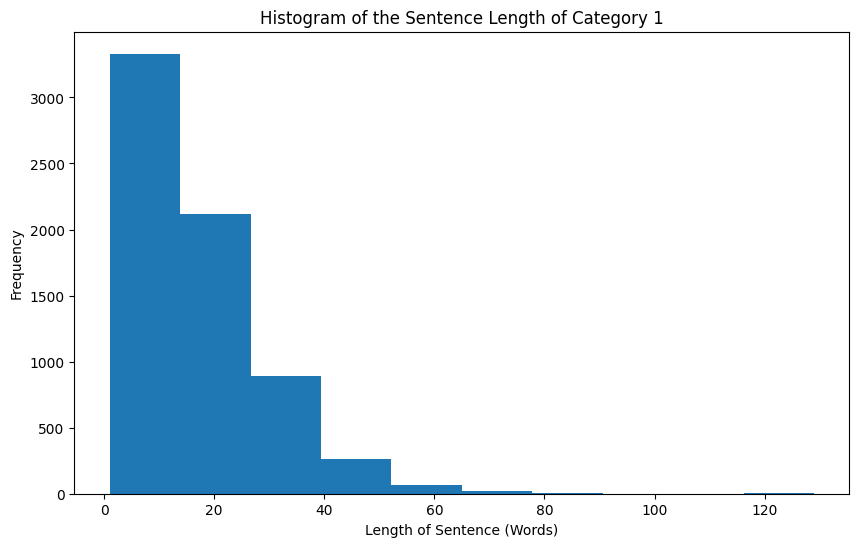

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(expanded1)
plt.title("Histogram of the Sentence Length of Category 1")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

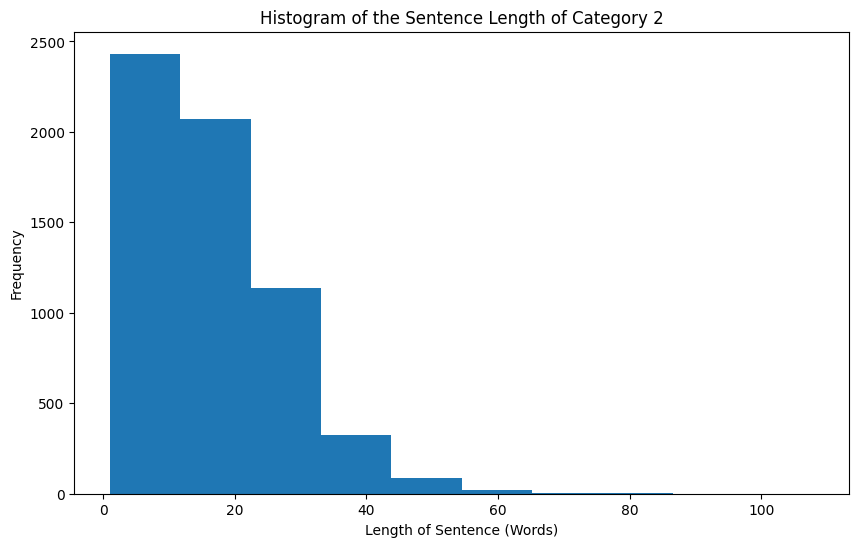

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(expanded2)
plt.title("Histogram of the Sentence Length of Category 2")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

In [34]:
# ?? Total number of bi-gram occurences per category. min/max/avg

In [35]:
def collect_bigrams(tokens):
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences

In [36]:
bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [37]:
bigrams_longest1 = collect_bigrams(longest_sentence1.split(' '))
bigrams_longest2 = collect_bigrams(longest_sentence2.split(' '))

In [38]:
bigrams_shortest1 = collect_bigrams(shortest_sentence1.split(' '))
bigrams_shortest2 = collect_bigrams(shortest_sentence2.split(' '))

In [39]:
print("Number of unique bigram occurences in Category 1:", len(bigrams1))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))
print("Number of unique bigram occurences in Category 2:", len(bigrams2))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))

Number of unique bigram occurences in Category 1: 58370
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116
Number of unique bigram occurences in Category 2: 48210
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116


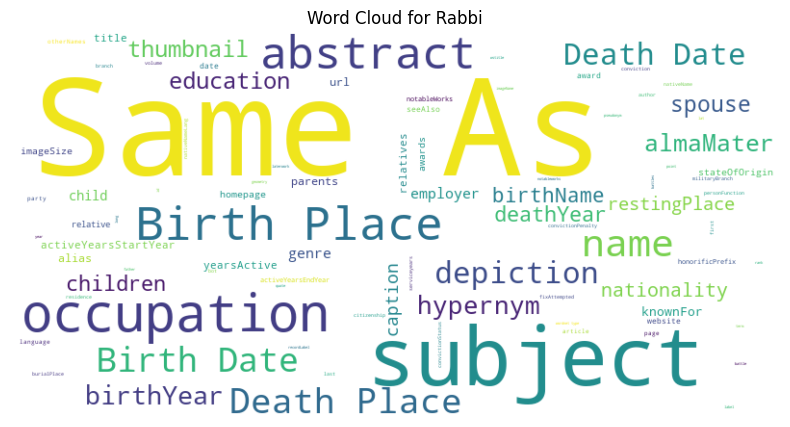

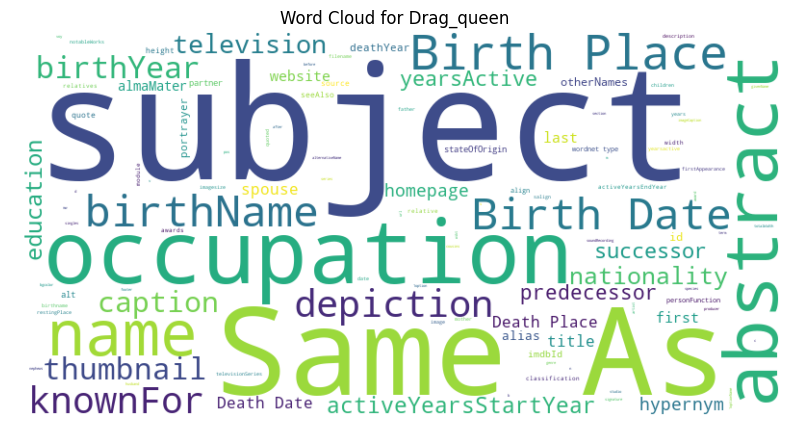

In [40]:
def load_data(category):
    files = glob.glob(f'./data/*{category}*.json') 
    data = []
    for file in files:
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

def format_property_name(uri):
    name = uri.split('/')[-1]
    name = name.split('#')[-1]
    name = name.replace('_', ' ')
    replacements = {
        'PageID': 'Page ID',
        'URL': 'URL',
        'birthDate': 'Birth Date',
        'deathDate': 'Death Date',
        'birthPlace': 'Birth Place',
        'deathPlace': 'Death Place',
        'sameAs': 'Same As'
    }
    for key, value in replacements.items():
        name = name.replace(key, value)
    return name

def count_properties(data, exclude):
    property_counter = Counter()
    for triple in data:
        property_uri = triple['predicate']
        if property_uri not in exclude:
            simple_property_name = format_property_name(property_uri)
            property_counter[simple_property_name] += 1
    return property_counter

def make_wordcloud(properties_counter, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(properties_counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()
#I excluded all the cases that were not relevant to describe the person. However: it does still look kinda ugly.
exclusions = [
    "http://dbpedia.org/ontology/wikiPageExternalLink",
    "http://dbpedia.org/ontology/wikiPageRevisionID",
    "http://dbpedia.org/ontology/wikiPageWikiLink",
    "http://dbpedia.org/property/wikiPageUsesTemplate",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://dbpedia.org/ontology/wikiPageLength",
    "http://dbpedia.org/ontology/wikiPageID",
    "http://xmlns.com/foaf/0.1/isPrimaryTopicOf",
    "http://www.w3.org/ns/prov#wasDerivedFrom"
]

for category in ['Rabbi', 'Drag_queen']:
    data = load_data(category)
    properties = count_properties(data, exclusions)
    make_wordcloud(properties, category)


Statistics for Rabbi:
Minimum facts: 62
Maximum facts: 9092
Average facts: 235.75


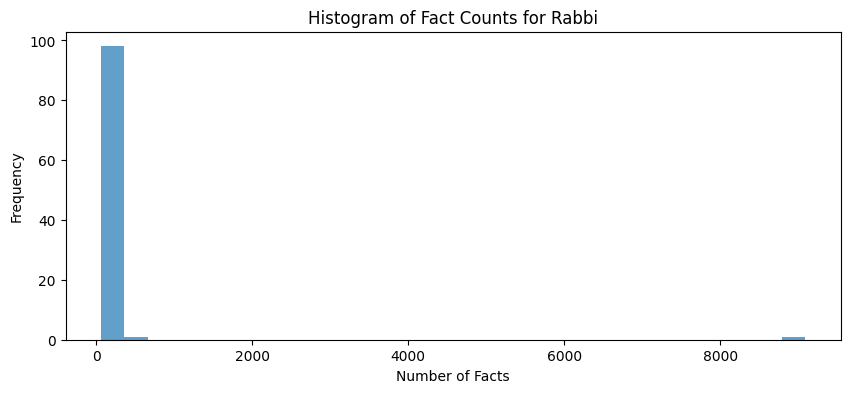

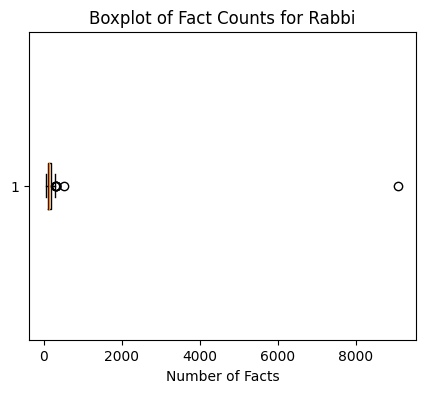

Statistics for Drag_queen:
Minimum facts: 14
Maximum facts: 716
Average facts: 149.72


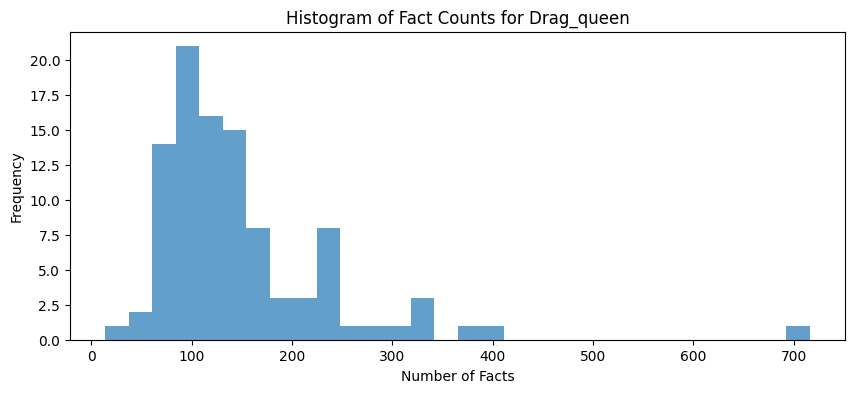

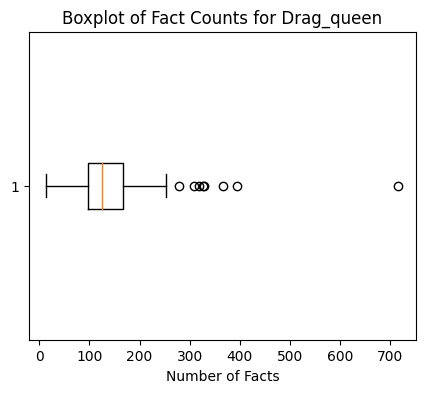

In [41]:
# Create histograms and boxplot for number of facts per category. min/max/avg

def load_and_count_facts(category):
    files = glob.glob(f'./data/*{category}*.json')
    fact_counts = []
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        unique_facts = set((fact['subject'], fact['predicate'], fact['object']) for fact in data)
        fact_counts.append(len(unique_facts))
    return fact_counts

def visualize_data(categories):
    for category in categories:
        fact_counts = load_and_count_facts(category)
        print(f"Statistics for {category}:")
        print(f"Minimum facts: {min(fact_counts)}")
        print(f"Maximum facts: {max(fact_counts)}")
        print(f"Average facts: {sum(fact_counts) / len(fact_counts)}")

        
        plt.figure(figsize=(10, 4))
        plt.hist(fact_counts, bins=30, alpha=0.7, label=f'{category} Facts')
        plt.title(f'Histogram of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.ylabel('Frequency')
        plt.show()

        
        plt.figure(figsize=(5, 4))
        plt.boxplot(fact_counts, vert=False)
        plt.title(f'Boxplot of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.show()


categories = ['Rabbi', 'Drag_queen'] #For some reason the Rabbi's graphs look *awful*


visualize_data(categories)


In [42]:
#To linearize the RDFs 

import json
import glob

def load_and_linearize(category):
    path_pattern = f'./data/*{category}*.json'
    linearized_data = []

    for file_path in glob.glob(path_pattern):
        with open(file_path, 'r') as file:
            data = json.load(file)
            for triple in data:
                
                subject = extract_and_clean(triple['subject'])
                predicate = extract_and_clean(triple['predicate'])
                object_ = extract_and_clean(triple['object'])
                
               
                linearized_string = f"{subject} {predicate} {object_}"
                linearized_data.append(linearized_string)

    return linearized_data

def extract_and_clean(uri):
    
    parts = uri.split('/')
    last_part = parts[-1]
    
    if '#' in last_part:
        last_part = last_part.split('#')[-1]
    
    return last_part.replace('_', ' ').replace('-', ' ')


categories = ['Rabbi', 'Drag_queen']
linearized_data = {}

for category in categories:
    linearized_data[category] = load_and_linearize(category)


linearized_rabbi = linearized_data['Rabbi']
linearized_drag_queen = linearized_data['Drag_queen']

### To clean the elements of each list ### 

#remove repetitions
linearized_rabbi_rdf = list(set(linearized_rabbi))
linearized_drag_queen_rdf = list(set(linearized_drag_queen))

#remove > symbol

linearized_rabbi_rdf = [re.sub('>', '', rabbi) for rabbi in linearized_rabbi_rdf]
linearized_drag_queen_rdf = [re.sub('>', '', dg) for dg in linearized_drag_queen_rdf]


In [141]:
from sklearn.utils import shuffle
# Creating a separate data frame with the RDFs

df_rabbi = pd.DataFrame({'text': linearized_rabbi_rdf, 'category': 'Rabbi'})

# Create DataFrame for Drag Queen texts
df_drag_queen = pd.DataFrame({'text': linearized_drag_queen_rdf, 'category': 'Drag Queen'})

# Concatenate both DataFrames into a single DataFrame
df_rdf = pd.concat([df_rabbi, df_drag_queen], ignore_index=True)

# Shuffle the DataFrame if needed
df_rdf = df_rdf.sample(frac=1, random_state=42)
df_rdf = shuffle(df_rdf)
df_rdf = df_rdf.reset_index(drop=True) 
df_rdf

,text,category
0,Anita Wigl'it wikiPageUsesTemplate Template:Ru...,Drag Queen
1,Barry Freundel birthPlace New York (state),Rabbi
2,Adore Delano type Thing,Drag Queen
3,Bob the Drag Queen wikiPageWikiLink File:DSC05...,Drag Queen
4,Jackie Cox (drag queen) wikiPageRevisionID 111...,Drag Queen
...,...,...
36722,Josy Eisenberg sameAs Q113803806,Rabbi
36723,Jaida Essence Hall wikiPageUsesTemplate Templa...,Drag Queen
36724,Meir Simcha of Dvinsk type WikicatKohanimWrite...,Rabbi
36725,Uri Regev sameAs 4wDHZ,Rabbi


## Clustering

### Train KMeans clustering (n_clusters=2). Cluster based on text (?) and, separately, on facts

### Clustering based on text 

In [134]:
#shuffling data


df = shuffle(df)
df = df.reset_index(drop=True) 
df

,text,category,clean_text,tokenized,numerical_category
0,Vinegar Strokes (born 21 August 1984) is the s...,Drag queen,vinegar strokes born 21 august 1984 is the s...,"[vinegar, strokes, born, 21, august, 1984, is,...",0
1,"Jovan Jordan Bridges (born August 22, 1993), k...",Drag queen,jovan jordan bridges born august 22 1993 k...,"[jovan, jordan, bridges, born, august, 22, 199...",0
2,"Heinemann Vogelstein (February 13, 1841 - Augu...",Rabbi,heinemann vogelstein february 13 1841 - augu...,"[heinemann, vogelstein, february, 13, 1841, -,...",1
3,"Cameron Clayton, better known by the stage nam...",Drag queen,cameron clayton better known by the stage nam...,"[cameron, clayton, better, known, by, the, sta...",0
4,Scarlett Harlett is the stage name of Harry Lu...,Drag queen,scarlett harlett is the stage name of harry lu...,"[scarlett, harlett, is, the, stage, name, of, ...",0
...,...,...,...,...,...
195,Rebecca Dubowe is the first deaf woman to be o...,Rabbi,rebecca dubowe is the first deaf woman to be o...,"[rebecca, dubowe, is, the, first, deaf, woman,...",1
196,"Richard Lowell Rubenstein (January 8, 1924 – M...",Rabbi,richard lowell rubenstein january 8 1924 – m...,"[richard, lowell, rubenstein, january, 8, 1924...",1
197,"Julian Riley, known professionally as Elektra ...",Drag queen,julian riley known professionally as elektra ...,"[julian, riley, known, professionally, as, ele...",0
198,"Antoine Ashley (December 17, 1984 – October 1,...",Drag queen,antoine ashley december 17 1984 – october 1 ...,"[antoine, ashley, december, 17, 1984, –, octob...",0


In [135]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag queen": 0, "Rabbi" : 1}

#applying to df
df['numerical_category'] = df['category'].map(category_mapping)
df.head()

,text,category,clean_text,tokenized,numerical_category
0,Vinegar Strokes (born 21 August 1984) is the s...,Drag queen,vinegar strokes born 21 august 1984 is the s...,"[vinegar, strokes, born, 21, august, 1984, is,...",0
1,"Jovan Jordan Bridges (born August 22, 1993), k...",Drag queen,jovan jordan bridges born august 22 1993 k...,"[jovan, jordan, bridges, born, august, 22, 199...",0
2,"Heinemann Vogelstein (February 13, 1841 - Augu...",Rabbi,heinemann vogelstein february 13 1841 - augu...,"[heinemann, vogelstein, february, 13, 1841, -,...",1
3,"Cameron Clayton, better known by the stage nam...",Drag queen,cameron clayton better known by the stage nam...,"[cameron, clayton, better, known, by, the, sta...",0
4,Scarlett Harlett is the stage name of Harry Lu...,Drag queen,scarlett harlett is the stage name of harry lu...,"[scarlett, harlett, is, the, stage, name, of, ...",0


In [136]:
#Vectorizing Inputs [TF-IDF]

X = df['clean_text']
Y = df['numerical_category']
X

0      vinegar strokes  born 21 august 1984  is the s...
1      jovan jordan bridges  born august 22  1993   k...
2      heinemann vogelstein  february 13  1841 - augu...
3      cameron clayton  better known by the stage nam...
4      scarlett harlett is the stage name of harry lu...
                             ...                        
195    rebecca dubowe is the first deaf woman to be o...
196    richard lowell rubenstein  january 8  1924 – m...
197    julian riley  known professionally as elektra ...
198    antoine ashley  december 17  1984 – october 1 ...
199    alexis mateo pacheco  born july 24  1979   bes...
Name: clean_text, Length: 200, dtype: object

In [137]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [138]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
X_train_vectors= tfidf_vectorizer.fit_transform(X_train)
X_test_vectors= tfidf_vectorizer.fit_transform(X_test)
X_vectors = tfidf_vectorizer.fit_transform(X)

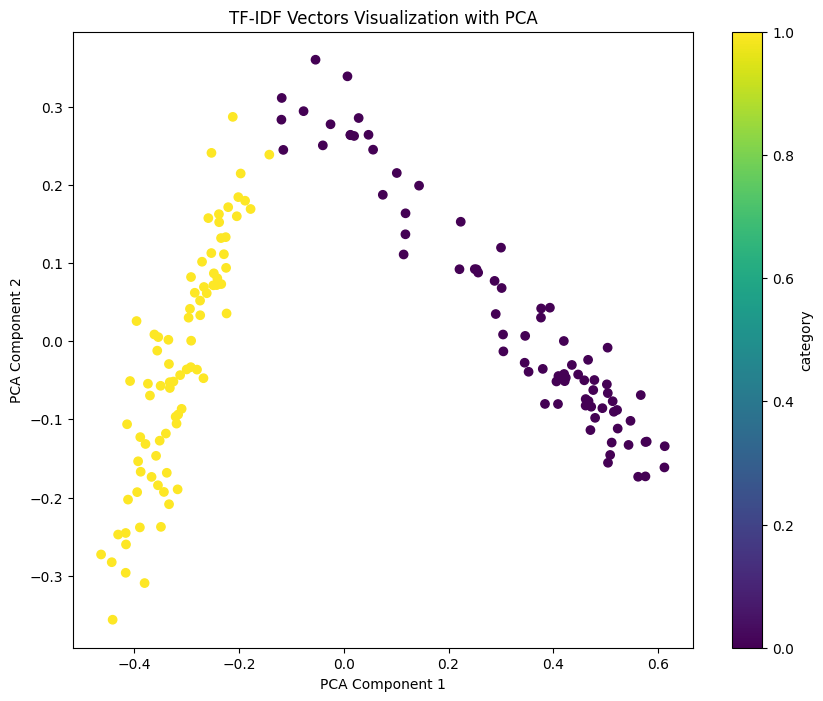

In [139]:
from sklearn.decomposition import PCA

# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Plot PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization with PCA')
plt.colorbar(label='category')
plt.show()


In [116]:
#Training a K-means clustering model
from sklearn.cluster import KMeans

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_vectors)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels = km.labels_
clusters = predicted_labels.tolist()



In [117]:
train_data = {'text': X_train, 'category': y_train, 'cluster' : clusters}
df_train = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train

,text,category,cluster
79,heidi n closet is the stage name of trevien an...,1,0
197,the ziegler school of rabbinic studies inform...,0,1
38,dexter clift born 8 april 1998 known profes...,1,0
24,justin omar mooijer born 9 april 1992 known...,1,0
122,susan schnur born april 21 1951 is an ameri...,0,1
...,...,...,...
106,david feuerwerker october 2 1912 – june 20 ...,0,1
14,roy r haylock born june 27 1975 better kn...,1,0
92,yuhua hamasaki is the stage name of yuhua ou ...,1,0
179,rabbi jason klein became the first openly gay ...,0,1


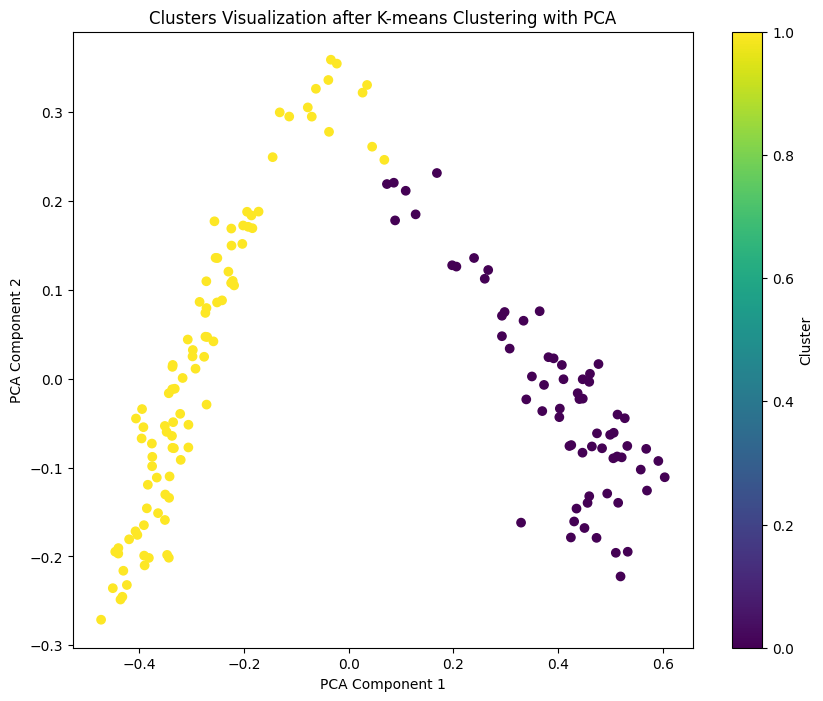

In [118]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

### Compute supervised and unsupervised metrics and visualizations to compare results

In [119]:
#$Supervised Metrics

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, predicted_labels))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train, predicted_labels))


Homogeneity: 0.659
Completeness: 0.674
V-measure: 0.667
Adjusted Rand-Index: 0.700


In [120]:
km.fit(X_test_vectors)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_test = km.labels_
clusters_test = predicted_labels_test.tolist()


In [121]:
test_data = {'text': X_test, 'category': y_test, 'cluster' : clusters_test}
df_test = pd.DataFrame(test_data,columns=['text','category','cluster'])
df_test

,text,category,cluster
95,dovid raskin 1927–2011 was a rabbi associate...,0,1
15,lil miss hot mess born c 1984 is an america...,1,0
30,rupaul andre charles born november 17 1960 ...,1,0
158,josé julio sarria december 13 1922 – august ...,1,1
128,rabbi adin even-israel steinsaltz 11 july 193...,0,1
115,jared johnson born december 9 1988 best kn...,1,0
69,manoel dias soeiro dutch pronunciation maːˈ...,0,1
170,elie abadie arabic ايلي عبادي is senior rab...,0,1
174,nine west also known as 9 west is an america...,1,1
45,aryeh leib frumkin hebrew אריה ליב פרומקין ...,0,1


In [66]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, predicted_labels_test))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, predicted_labels_test))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, predicted_labels_test))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_test, predicted_labels_test))


Homogeneity: 0.683
Completeness: 0.687
V-measure: 0.685
Adjusted Rand-Index: 0.715


### Clustering based on facts

In [144]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag Queen": 0, "Rabbi" : 1}

#applying to df
df_rdf['numerical_category'] = df_rdf['category'].map(category_mapping)
df_rdf.tail()

,text,category,numerical_category
36722,Josy Eisenberg sameAs Q113803806,Rabbi,1
36723,Jaida Essence Hall wikiPageUsesTemplate Templa...,Drag Queen,0
36724,Meir Simcha of Dvinsk type WikicatKohanimWrite...,Rabbi,1
36725,Uri Regev sameAs 4wDHZ,Rabbi,1
36726,Josy Eisenberg sameAs 22510334,Rabbi,1


In [147]:
X_rdf = df_rdf['text']
Y_rdf = df_rdf['numerical_category']
X_rdf

0        Anita Wigl'it wikiPageUsesTemplate Template:Ru...
1               Barry Freundel birthPlace New York (state)
2                                  Adore Delano type Thing
3        Bob the Drag Queen wikiPageWikiLink File:DSC05...
4        Jackie Cox (drag queen) wikiPageRevisionID 111...
                               ...                        
36722                     Josy Eisenberg sameAs Q113803806
36723    Jaida Essence Hall wikiPageUsesTemplate Templa...
36724    Meir Simcha of Dvinsk type WikicatKohanimWrite...
36725                               Uri Regev sameAs 4wDHZ
36726                       Josy Eisenberg sameAs 22510334
Name: text, Length: 36727, dtype: object

In [149]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_rdf, X_test_rdf, y_train_rdf, y_test_rdf = train_test_split(X_rdf, Y_rdf, test_size=0.2, random_state=42)

In [150]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
X_train_rdf_vec= tfidf_vectorizer.fit_transform(X_train_rdf)
X_test_rdf_vec= tfidf_vectorizer.fit_transform(X_test_rdf)
X_rdf_vec = tfidf_vectorizer.fit_transform(X_rdf)

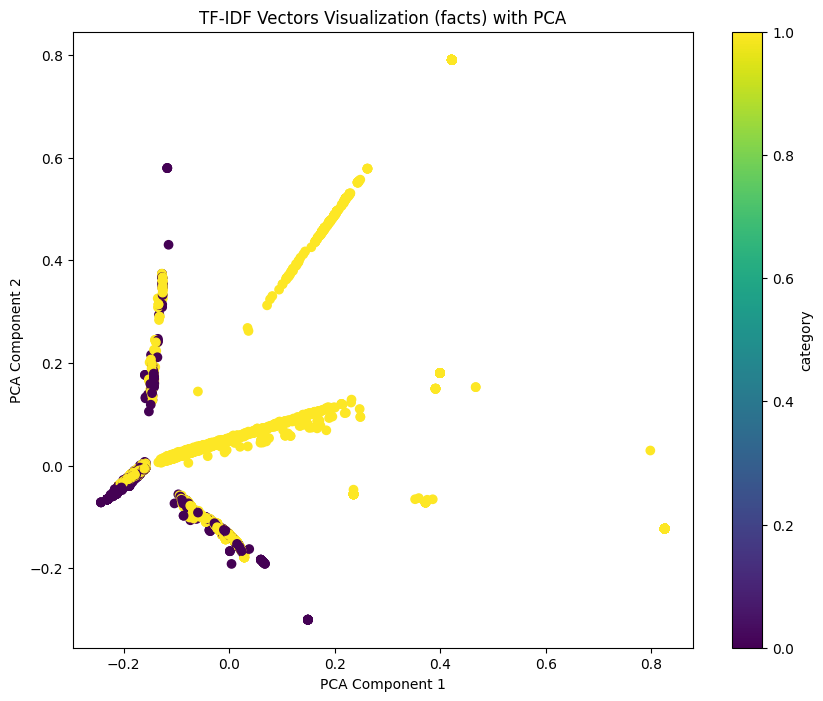

In [151]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_rdf_pca = pca.fit_transform(X_train_rdf_vec.toarray())

# Plot PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_rdf_pca[:, 0], X_rdf_pca[:, 1], c=y_train_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization (facts) with PCA')
plt.colorbar(label='category')
plt.show()


In [153]:
#Training a K-means clustering model
from sklearn.cluster import KMeans

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_rdf_vec)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_rdf = km.labels_
clusters_rdf = predicted_labels_rdf.tolist()



In [154]:
train_data = {'text': X_train_rdf, 'category': y_train_rdf, 'cluster' : clusters_rdf}
df_train_rdf = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train_rdf

,text,category,cluster
15137,Arthur Waskow subject Category:Swarthmore Coll...,1,1
22805,Gothy Kendoll wikiPageUsesTemplate Template:Ru...,0,1
17712,Barry Freundel wikiPageWikiLink Columbia Unive...,1,1
7137,Envy Peru subject Category:Drag Race Holland w...,0,1
12139,Moses Schorr wikiPageWikiLink Slavic studies,1,1
...,...,...,...
16850,Sir Lady Java subject Category:LGBT people fro...,0,1
6265,Menasseh Ben Israel wikiPageWikiLink Hebrew la...,1,1
11284,Josy Eisenberg sameAs 311835481,1,0
860,David Seth Kirshner wikiPageWikiLink Activist,1,1


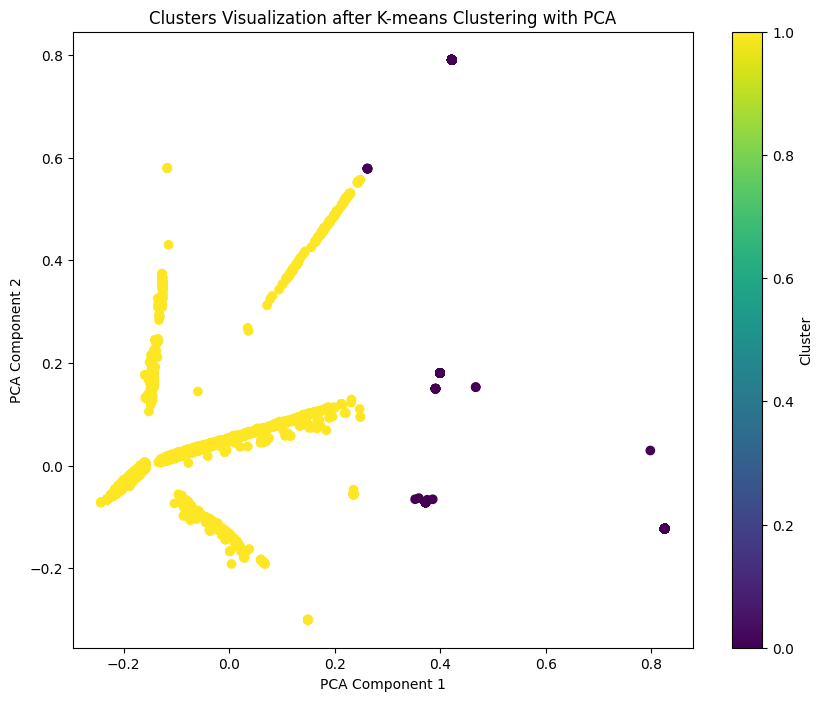

In [155]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca_rdf = pca.fit_transform(X_train_rdf_vec.toarray())

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_rdf[:, 0], X_pca_rdf[:, 1], c=predicted_labels_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

### Compute supervised and unsupervised metrics and visualizations to compare results

In [156]:
#$Supervised Metrics

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train_rdf, predicted_labels_rdf))
print("Completeness: %0.3f" % metrics.completeness_score(y_train_rdf, predicted_labels_rdf))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train_rdf, predicted_labels_rdf))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train_rdf, predicted_labels_rdf))


Homogeneity: 0.146
Completeness: 0.208
V-measure: 0.171
Adjusted Rand-Index: -0.009


In [158]:
km.fit(X_test_rdf_vec)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_test_rdf = km.labels_
clusters_test_rdf = predicted_labels_test_rdf.tolist()


In [159]:
test_data = {'text': X_test, 'category': y_test, 'cluster' : clusters_test_rdf}
df_test_rdf = pd.DataFrame(test_data,columns=['text','category','cluster'])
df_test_rdf

,text,category,cluster
5030,RuPaul type Organism100004475,0,0
1291,Silky Nutmeg Ganache subject Category:RuPaul's...,0,0
11020,Mordechai Gutnick wikiPageWikiLink Menachem Me...,1,0
11574,Michael Lerner (rabbi) wikiPageUsesTemplate Te...,1,0
27073,Josy Eisenberg sameAs 109008868X,1,1
...,...,...,...
13804,Harold Kushner type Thing,1,0
33245,Shmuley Boteach type Object100002684,1,0
3116,"Uri Zohar wikiPageWikiLink File:אורי זוהר, מתו...",1,0
4450,Josy Eisenberg sameAs 100288159,1,1


In [160]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test_rdf, predicted_labels_test_rdf))
print("Completeness: %0.3f" % metrics.completeness_score(y_test_rdf, predicted_labels_test_rdf))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test_rdf, predicted_labels_test_rdf))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_test_rdf, predicted_labels_test_rdf))


Homogeneity: 0.146
Completeness: 0.209
V-measure: 0.172
Adjusted Rand-Index: -0.008


In [ ]:
# Function that process a document and return the set of named entities(NEs) (Spacy)

In [ ]:
# Same as above but with Stanza

In [ ]:
# Get statistics for each output (avg/min/max number of NEs)

In [ ]:
# Get statistics for each output (avg/min/max number of words (unclear use of word 'word'))

In [ ]:
# Visualize the above 2 statistics (per category, per package)

In [ ]:
# Write a function that takes a single document and performs the following 5 tasks

In [ ]:
    # Returns # of spans that both packages agree on

In [ ]:
    # Returns # of partial agreements on spans

In [ ]:
    # Returns for each package # of spans that one package predicted as a NE and the other did not

In [ ]:
    # Returns for all spans with full and partial agreement, agreement about NE types (aka Person, Location, Organisation, etc.)

In [ ]:
    # Visualize the above statistics

In [ ]:
# For each set of NEs predicted by each package, how many of them can be found in the knowledge graph (KG)

In [ ]:
# For each package, the ratio of predicted NEs that can be found in the KG of a person

In [ ]:
# Bonus points